In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import hypernetx as hnx
from scipy.stats import zscore
import networkx as nx
import nwhy

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
def filter_value(df, p1=0, p2=1):
    '''
    Transform the values of a dataframe into a table of 0's and 1's based 
    on a threshold value (p).
    
    Parameters
    ----------
    df : pandas dataframe
        values should be numeric
    p : float
        threshold value so that values in df turn to 1 if between p1 and p2, inclusive,
        and 0 otherwise
    
    Returns
    -------
    ndf : pandas dataframe
    '''
    ndf = df.copy()
    for col in ndf.columns:
        try:
            ndf[col] = ndf[col].map(lambda x : (x >= p1 and x <= p2)*1)
        except:
            return col
    return ndf

In [5]:
def s_harmonic_closeness_centrality(H,edge=None,restrict_to=None,s=1):
    '''
    A centrality measure for an s-edge subgraph of H. A value equal to 1 means the s-edge
    intersects every other s-edge in H. All values range between 0 and 1.
    Edges of size less than s return 0. If H contains only one s-edge a 0 is returned.
    
    Parameters:
    -----------
    H : hnx.Hypergraph
    edge : str or hnx.Entity, optional
        an edge or uid of an edge in H
        If None then a dictionary of values for all s-edges is returned.
    s : int
        minimum size of edges to be considered
        
    Returns:
    --------
     : dict or float
        returns the s-harmonic closeness centrality value of the edges, a number between 0 and 1 inclusive.
        If edge=None a dictionary of values for each s-edge in H is returned. 
        If edge then a single value is returned. 
        
    '''
    ## Confirm there is at least 1 s edge for which we can compute the centrality
    ## Find all s-edges
    if edge and len(H.edges[edge]) < s:
        return 0
    
    Es = [e for e in H.edges if len(H.edges[e])>s]
    if edge:
        edges = [H.edges[edge].uid]
    else:
        edges = Es
        
        
    A,coldict = H.edge_adjacency_matrix(s=s,index=True)
    g = nx.from_scipy_sparse_matrix(A)
    ckey = {v:k for k,v in coldict.items()}
    
    def temp(e,f):
        try:
            return nx.shortest_path_length(g,ckey[e],ckey[f])
        except:
            return np.inf
        
    
    ## confirm there are at least 2 s-edges
    ## we follow the NX convention that the s-closeness centrality of a single edge Hypergraph is 0
    output = {}   
    if not bool(Es) or len(Es)==1:
        output = {e : 0 for e in edges}
    else:
        for e in edges: 
            summands_recip = [temp(e,f) for f in Es if f!= e]
            summands = [1/x for x in summands_recip if not x == np.inf and x != 0]
            output[e] = 1/(len(Es)-1)*sum(summands)            
    if len(edges) ==1:
        return output[edges[0]]
    else:
        return output

In [6]:
def noborder(w=5, h=5):
    fig, ax = plt.subplots(1, 1, figsize=(w,h))
    ax.axis('off')

# Compute the s-harmonic closeness centrality for bigTrans


## Read in data as a pandas data frame with genes on rows

In [7]:
datadir = '.'
datafile = 'bigTrans.csv'
# metafile = f'{datadir}/transMeta.txt'

In [8]:
## Read the data file into a pandas array 
df = pd.read_csv(datafile)
df = df.set_index('Protein')

In [9]:
df

,EB1_WT_0h__b,EB1_WT_0h__p,EB1_WT_00h__b,EB1_WT_00h__p,EB1_WT_8h__b,EB1_WT_8h__p,EB1_WT_18h__b,EB1_WT_18h__p,EB1_WT_24h__b,EB1_WT_24h__p,...,mouse_ln_WNV_WT_6d__b,mouse_ln_WNV_WT_6d__p,mouse_ln_WNV_E218A_1d__b,mouse_ln_WNV_E218A_1d__p,mouse_ln_WNV_E218A_2d__b,mouse_ln_WNV_E218A_2d__p,mouse_ln_WNV_E218A_4d__b,mouse_ln_WNV_E218A_4d__p,mouse_ln_WNV_E218A_6d__b,mouse_ln_WNV_E218A_6d__p
Protein,,,,,,,,,,,,,,,,,,,,,
AAAS,-0.053539,0.897905,-0.021629,0.971758,0.069450,0.893481,0.390366,0.150667,0.073836,0.705193,...,0.818601,0.199452,0.675964,0.000681,1.295524,0.000307,1.474642,0.000588,1.359757,0.012836
AACS,0.031504,0.896717,0.131252,0.409202,0.309998,0.244921,0.401375,0.037433,0.165346,0.354110,...,-1.549177,0.038906,-0.788553,0.123942,-0.743268,0.038090,-0.632166,0.112165,-1.220868,0.041723
AADAC,-0.041660,0.837731,0.031732,0.905520,-0.106712,0.351493,-0.224353,0.169825,-0.045614,0.834415,...,0.036319,0.768323,0.030294,0.781156,0.030260,0.748385,0.020523,0.891355,0.009379,0.963882
AAK1,0.139425,0.507731,0.148185,0.805341,0.251240,0.196918,0.290396,0.058642,0.383917,0.082190,...,0.235774,0.359214,0.871901,0.009966,1.341327,0.034060,-0.485618,0.168506,-1.095028,0.100790
AAMP,0.139837,0.470499,0.005684,0.988458,0.077773,0.496487,0.128518,0.292702,0.132485,0.179721,...,-1.181211,0.237053,0.389658,0.346917,-0.150656,0.560934,-0.244075,0.553876,-0.914955,0.221456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.045434,0.824089,-0.015377,0.962803,-0.169418,0.279589,-0.392423,0.056689,0.231872,0.230117,...,-0.340128,0.200774,-0.171930,0.231725,-0.467780,0.081835,-0.191643,0.228520,-0.378330,0.051729
ZYG11B,-0.065778,0.738327,0.048467,0.837573,-0.124070,0.334889,-0.093041,0.241951,-0.090427,0.654161,...,0.540451,0.106912,0.225615,0.032041,0.488816,0.034831,-0.455465,0.066315,-0.669396,0.069482
ZYX,0.045843,0.935855,-0.164044,0.782415,0.114723,0.867864,0.658516,0.042476,0.456055,0.077666,...,-0.222580,0.388599,0.041345,0.749071,-0.546407,0.029197,0.138742,0.509172,-0.290648,0.218790


In [10]:
## We restrict to the columns giving the fold changes
bdf = df.filter(regex='b$',axis=1);bdf

,EB1_WT_0h__b,EB1_WT_00h__b,EB1_WT_8h__b,EB1_WT_18h__b,EB1_WT_24h__b,EB1_WT_48h__b,EB1_mucin_0h__b,EB1_mucin_00h__b,EB1_mucin_8h__b,EB1_mucin_18h__b,...,mouse_cb_WNV_WT218A_4d__b,mouse_cb_WNV_WT218A_6d__b,mouse_ln_WNV_WT_1d__b,mouse_ln_WNV_WT_2d__b,mouse_ln_WNV_WT_4d__b,mouse_ln_WNV_WT_6d__b,mouse_ln_WNV_E218A_1d__b,mouse_ln_WNV_E218A_2d__b,mouse_ln_WNV_E218A_4d__b,mouse_ln_WNV_E218A_6d__b
Protein,,,,,,,,,,,,,,,,,,,,,
AAAS,-0.053539,-0.021629,0.069450,0.390366,0.073836,-0.442246,-0.082826,-0.422886,-0.045865,0.308248,...,0.110832,0.106307,-0.164211,0.384582,0.661209,0.818601,0.675964,1.295524,1.474642,1.359757
AACS,0.031504,0.131252,0.309998,0.401375,0.165346,0.079663,-0.291830,-0.386167,0.207874,0.335756,...,-0.786648,-0.234909,-0.942312,-0.758240,-0.742127,-1.549177,-0.788553,-0.743268,-0.632166,-1.220868
AADAC,-0.041660,0.031732,-0.106712,-0.224353,-0.045614,-0.890692,-0.040650,0.053375,-0.220946,-0.279067,...,-0.030368,-0.041964,0.070461,0.062098,0.027516,0.036319,0.030294,0.030260,0.020523,0.009379
AAK1,0.139425,0.148185,0.251240,0.290396,0.383917,0.680079,-0.185509,0.495312,-0.189335,0.234855,...,-1.645084,-0.540221,0.257469,-0.243665,-0.326640,0.235774,0.871901,1.341327,-0.485618,-1.095028
AAMP,0.139837,0.005684,0.077773,0.128518,0.132485,0.122469,0.025393,0.055635,0.113951,0.080511,...,-1.147891,-0.329626,-0.670756,-0.411586,-0.751645,-1.181211,0.389658,-0.150656,-0.244075,-0.914955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.045434,-0.015377,-0.169418,-0.392423,0.231872,-0.102981,-0.152677,-0.130969,-0.121257,-0.187774,...,-0.550714,-0.352116,-0.194426,0.450063,-0.362686,-0.340128,-0.171930,-0.467780,-0.191643,-0.378330
ZYG11B,-0.065778,0.048467,-0.124070,-0.093041,-0.090427,-0.550867,-0.152835,-0.038874,-0.064925,-0.487526,...,-0.949243,0.304041,0.625628,0.796009,0.479204,0.540451,0.225615,0.488816,-0.455465,-0.669396
ZYX,0.045843,-0.164044,0.114723,0.658516,0.456055,0.298952,-0.443505,-0.754256,-0.023101,0.849493,...,-0.106078,-0.364817,-0.107176,-0.495370,0.234681,-0.222580,0.041345,-0.546407,0.138742,-0.290648


In [11]:
## normalize the dataframe by taking z-scores
zbdf = abs(bdf.apply(zscore));zbdf

,EB1_WT_0h__b,EB1_WT_00h__b,EB1_WT_8h__b,EB1_WT_18h__b,EB1_WT_24h__b,EB1_WT_48h__b,EB1_mucin_0h__b,EB1_mucin_00h__b,EB1_mucin_8h__b,EB1_mucin_18h__b,...,mouse_cb_WNV_WT218A_4d__b,mouse_cb_WNV_WT218A_6d__b,mouse_ln_WNV_WT_1d__b,mouse_ln_WNV_WT_2d__b,mouse_ln_WNV_WT_4d__b,mouse_ln_WNV_WT_6d__b,mouse_ln_WNV_E218A_1d__b,mouse_ln_WNV_E218A_2d__b,mouse_ln_WNV_E218A_4d__b,mouse_ln_WNV_E218A_6d__b
Protein,,,,,,,,,,,,,,,,,,,,,
AAAS,0.385565,0.238070,0.443872,1.463033,0.158425,1.145265,0.260249,2.064284,0.379907,0.953880,...,0.385399,0.447249,0.119840,0.836579,1.291596,1.311356,0.969919,1.879485,2.509792,1.883533
AACS,0.164414,1.005465,2.345166,1.507704,0.606929,0.163841,1.217533,1.890122,1.473085,1.046324,...,0.706847,0.358692,1.394904,0.985461,1.094888,1.613561,1.095892,0.670392,0.860191,1.092556
AADAC,0.308742,0.195965,0.948517,1.031329,0.427018,2.270104,0.067074,0.194677,1.658488,1.019828,...,0.213557,0.097038,0.264714,0.322433,0.213951,0.345003,0.059153,0.297044,0.183829,0.326218
AAK1,0.862342,1.143194,1.880740,1.057383,1.678182,1.669868,0.730559,2.290836,1.427638,0.707239,...,1.751575,1.079826,0.571162,0.165057,0.388318,0.591389,1.246303,1.936769,0.625779,0.947431
AAMP,0.865006,0.015907,0.509653,0.400525,0.445872,0.271212,0.235416,0.205397,0.787188,0.188556,...,1.146484,0.582409,0.949909,0.432778,1.111073,1.159014,0.566062,0.070777,0.239414,0.739763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.254497,0.187213,1.444144,1.713309,0.932982,0.294287,0.580180,0.679685,0.930479,0.713032,...,0.419712,0.635528,0.169353,0.940979,0.449617,0.120023,0.226099,0.325844,0.155545,0.120904
ZYG11B,0.464713,0.332092,1.085713,0.498499,0.646654,1.417720,0.580906,0.242868,0.519098,1.720368,...,0.904727,0.914288,1.174459,1.492532,0.982083,0.967757,0.334668,0.870552,0.577546,0.456574
ZYX,0.257142,1.396468,0.801706,2.551110,2.031740,0.713884,1.912234,3.636012,0.213669,2.772767,...,0.121416,0.665528,0.026378,0.566358,0.566252,0.025184,0.074742,0.424181,0.372929,0.019786


In [12]:
(zbdf > 0.2)*1

,EB1_WT_0h__b,EB1_WT_00h__b,EB1_WT_8h__b,EB1_WT_18h__b,EB1_WT_24h__b,EB1_WT_48h__b,EB1_mucin_0h__b,EB1_mucin_00h__b,EB1_mucin_8h__b,EB1_mucin_18h__b,...,mouse_cb_WNV_WT218A_4d__b,mouse_cb_WNV_WT218A_6d__b,mouse_ln_WNV_WT_1d__b,mouse_ln_WNV_WT_2d__b,mouse_ln_WNV_WT_4d__b,mouse_ln_WNV_WT_6d__b,mouse_ln_WNV_E218A_1d__b,mouse_ln_WNV_E218A_2d__b,mouse_ln_WNV_E218A_4d__b,mouse_ln_WNV_E218A_6d__b
Protein,,,,,,,,,,,,,,,,,,,,,
AAAS,1,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
AACS,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AADAC,1,0,1,1,1,1,0,0,1,1,...,1,0,1,1,1,1,0,1,0,1
AAK1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
AAMP,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,1,0,1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,1,1,0,0
ZYG11B,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ZYX,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,0,0,1,1,0


### Build hypergraph given z-score threshold
Edges are rows/genes, nodes correspond to columns/conditions. For each row find all columns which follow the z-score threshold condition. Those columns/conditions (nodes) form the edge for that row/gene.

In [13]:
%%time
## For each threshold value construct a hypergraph and compute the set of s-closeness centrality scores.

tdf = dict()

# We threshold on the outliers, values more than 3 standard deviations from the norm
steps = np.linspace(3,10,15)
for idx,v in enumerate(steps):
    temp2 = 1*(zbdf >= v)
    temp2 = temp2[temp2.any(axis=1)]
    temp3 = temp2.T[temp2.T.any(axis=1)]
    tdf[idx] = hnx.Hypergraph.from_dataframe(temp3,transpose=False,use_nwhy=False)


CPU times: user 1min 30s, sys: 1.49 s, total: 1min 32s
Wall time: 1min 35s


In [14]:
for idx in tdf:
    print(tdf[idx].shape)

(200, 4619)
(200, 3234)
(200, 2222)
(199, 1569)
(195, 1090)
(191, 785)
(185, 579)
(178, 420)
(169, 326)
(157, 258)
(143, 192)
(127, 152)
(113, 117)
(98, 98)
(85, 76)


In [15]:
## Grab the largest s-connected component from each hypergraph
cc = dict()
tcc = dict()
for idx in tdf:
    cc[idx] = sorted(tdf[idx].s_connected_components(),key=len,reverse=True)
    tcc[idx] = tdf[idx].restrict_to_edges(cc[idx][0])

In [16]:
cc[14]

[{'ARHGAP22',
  'BCL6',
  'BST2',
  'CCL2',
  'CCL20',
  'CCL5',
  'CXCL10',
  'CXCL11',
  'CXCL2',
  'CXCL5',
  'CXCL9',
  'DHRS9',
  'ECEL1',
  'EGR2',
  'EPAS1',
  'FAP',
  'FBXL8',
  'FOLR2',
  'FOS',
  'FOSB',
  'FOSL2',
  'IFI44',
  'IFIT1',
  'IFIT2',
  'IFIT3',
  'IL6',
  'IRF7',
  'ISG15',
  'KCNK1',
  'KIFC3',
  'MAP3K8',
  'MX1',
  'MX2',
  'MYLIP',
  'NR4A1',
  'NR4A2',
  'OAS2',
  'PAPD5',
  'PHF11',
  'PRM1',
  'RASD2',
  'RPS10',
  'RSAD2',
  'SAA1',
  'SNAI1',
  'SOCS3',
  'TRIM15',
  'TUBD1',
  'USP18',
  'ZBP1',
  'ZFP36',
  'ZZZ3'},
 {'CYP1A1',
  'DAND5',
  'EDAR',
  'FADS2',
  'HHIP',
  'PLA2G4F',
  'PNPLA5',
  'TSHZ3',
  'TUFM'},
 {'AREG', 'CHAC1', 'GDF15'},
 {'LRAT', 'PDE4B', 'THPO'},
 {'BRD7', 'DTD1'},
 {'NSD1', 'PPP1R12B'},
 {'CD46'},
 {'CBLB'},
 {'SNAI3'},
 {'DHX8'},
 {'LTC4S'}]

In [17]:
# steps

In [18]:
# tdf[14].shape,np.linspace(3,10,15)[14]

In [19]:
# import pickle
# with open('picklefiles/bigTrans_hyps_th_3_10_15.p','wb') as f:
#     pickle.dump(tdf,f)

In [20]:
# import pickle
# with open('picklefiles/bigTrans_hypergraphs_th_3to10_steps15.p','rb') as f:
#     tdf = pickle.load(f)

### Example threshold = 10

In [21]:
edf = tdf[14]
t = tdf[14].remove_static()

In [22]:
t.shape,tdf[14].shape ### not removing 0's!!!

((85, 76), (85, 76))

In [23]:
tdf[14].incidence_matrix(),tdf[14].dual().incidence_matrix()

(<85x76 sparse matrix of type '<class 'numpy.int64'>'
 	with 229 stored elements in Compressed Sparse Row format>,
 <76x85 sparse matrix of type '<class 'numpy.int64'>'
 	with 229 stored elements in Compressed Sparse Row format>)

Text(0.5, 1.0, 'Degree Distribution')

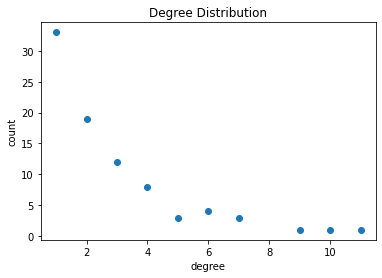

In [24]:
# node degree distribution
z_deg_dist = hnx.reports.degree_dist(edf, aggregated=True)
plt.scatter(z_deg_dist.keys(), z_deg_dist.values())
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Degree Distribution')


Text(0, 0.5, 'count (log)')

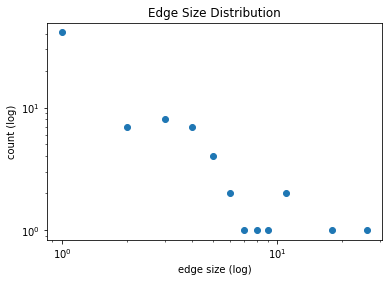

In [25]:
# edge size distribution
z_deg_dist = hnx.reports.edge_size_dist(edf, aggregated=True)
plt.scatter(z_deg_dist.keys(), z_deg_dist.values())
plt.yscale('log')
plt.xscale('log')
plt.title('Edge Size Distribution')
plt.xlabel('edge size (log)')
plt.ylabel('count (log)')

In [26]:
z_deg_dist

Counter({1: 41,
         3: 8,
         6: 2,
         18: 1,
         2: 7,
         4: 7,
         7: 1,
         9: 1,
         5: 4,
         11: 2,
         8: 1,
         26: 1})

### Get s-harmonic closeness centrality values

In [ ]:
tcc[14].shape

In [28]:
dtcc = tcc[14].remove_static()
hnx.s_betweenness_centrality(dtcc,s=1)

{'CXCL5': 0.0,
 'SNAI1': 0.0,
 'IFI44': 0.0018366013071895422,
 'RASD2': 0.0,
 'MAP3K8': 0.0,
 'ZZZ3': 0.11294117647058823,
 'SOCS3': 0.0,
 'FBXL8': 0.1568627450980392,
 'FOLR2': 0.0,
 'BST2': 0.0,
 'CXCL11': 0.01981792717086835,
 'NR4A2': 0.0,
 'KCNK1': 0.0,
 'EPAS1': 0.0,
 'MYLIP': 0.0,
 'ARHGAP22': 0.0,
 'TUBD1': 0.0,
 'IRF7': 0.0,
 'FAP': 0.0,
 'OAS2': 0.0009607843137254903,
 'PHF11': 0.000130718954248366,
 'RPS10': 0.0,
 'EGR2': 0.042352941176470586,
 'ECEL1': 0.0,
 'IL6': 0.0016638655462184874,
 'FOSB': 0.18274509803921568,
 'RSAD2': 0.02742577030812324,
 'CCL5': 0.0,
 'USP18': 0.0018366013071895422,
 'ZFP36': 0.0,
 'CXCL2': 0.0,
 'MX2': 0.0012324929971988796,
 'CXCL9': 0.0016638655462184874,
 'CCL2': 0.0047619047619047615,
 'DHRS9': 0.0,
 'BCL6': 0.0,
 'NR4A1': 0.11137254901960784,
 'FOS': 0.0792156862745098,
 'TRIM15': 0.0,
 'PAPD5': 0.0,
 'KIFC3': 0.0,
 'SAA1': 0.0,
 'IFIT3': 0.018392156862745097,
 'ZBP1': 0.0,
 'FOSL2': 0.0,
 'IFIT1': 0.15911577964519144,
 'IFIT2': 0.04872082

In [ ]:
cedf,rdict,cdict = edf.collapse_nodes_and_edges(return_equivalence_classes=True)

In [ ]:
cedf.shape

In [ ]:
celgs = {s:cedf.get_linegraph(s) for s in range(1,10)}

In [ ]:
scv = dict()
s=9
scv[s] = lgs[s].s_betweenness_centrality()

In [ ]:
scv = dict()
for s in range(1,5):
    scv[idx] = lgs[s].s_harmonic_closeness_centrality()
# with open('picklefiles/bigTrans_t10_hcc.p','wb') as f:
#     pickle.dump(scv,f)

In [ ]:
with open('picklefiles/bigTrans_t10_hcc.p','rb') as f:
    scv=pickle.load(f)

In [ ]:
raise
scv

In [ ]:
def srt(d):
    temp = dict(sorted([(k,v) for k,v in d.items()],key=lambda x: x[1],reverse=True))
    return temp
for k in scv:
    scv[k] = srt(scv[k])

In [ ]:
scv

In [ ]:
from collections import defaultdict
spec = defaultdict(list)
for idx in scv:
    for e,v in scv[idx]:
        spec[e].append(v)


In [ ]:
spec=dict(spec);spec

In [ ]:
# import pickle
# with open('picklefiles/bigTrans_t10_spec.p','wb') as f:
#     pickle.dump(spec,f)

In [ ]:
import pickle
with open('picklefiles/bigTrans_t10_spec.p','rb') as f:
    spec = pickle.load(f)

In [ ]:
spec

In [ ]:

t10spec=[(k,spec[k]) for k in list(scv[1].keys())];t10spec

In [ ]:
[x[1][0] for x in t10spec]

In [ ]:
specpos=defaultdict(list)
for idx in range(1,10):
    ln = len(scv[idx])
    for jdx,e in enumerate(scv[idx]):
        specpos[e[0]].append(35-jdx)
        

In [ ]:
len(scv[1])

In [ ]:
## Plot by relative position in scoring list - dupes are consecutive not coincident

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.set_yticks([v[0] for v in specpos.values()])
ax.set_yticklabels([k for k in specpos])
ax.set_xticks(range(10))
ax.set_xticklabels([str(x+1) for x in range(10)])
ax.set_xlabel('s',fontsize=14,color='r')
for p in specpos.values():
    ax.plot(p,marker='.')
plt.title('BigTrans\n s-harmonic closeness centrality for threshold=10\n(dupes are consecutive not coincident)',fontsize=14,color='r')

In [ ]:
def _srt(d,reverse=True):
    '''
    Helper method turns dictionary into list of ordered pairs ordered on first
    element of values
    Parameters:
    -----------
    d : dict
    Returns:
    --------
    temp : list
        replaces key value pairs with tuples ordered on second term
    '''
    temp = sorted([(k,v) for k,v in d.items()],key=lambda x: x[1],reverse=reverse)
    return temp

def order_by_position(scoresdict):
    '''
    Transforms a dictionary of dictionaries sorted by score: 
        `s:{k:score}` 
    s and int, k an identifier, score a float, 
    to a dictionary:
        `{k:[score_position]}`
    where score_position is the position of k relative to all other keys in the dict
    for that score position ordered on s

    Parameters:
    -----------
    scoresdict : dict of dicts
        for hyperbio s:{k:score} where score is an s-metric fore the given s and
        k is an object in a hypergraph
    Returns:
    --------
     : list
        [(k,[score_position])], k ordered on score_position[0]

    Note:
    -----
    The context for this comes from a list of monotonically decreasing
    s-measures which ultimately turn to 0. The score_position is where the score lies
    with respect to all of the other scores in the same list position for each k.
    The dict

    '''
    temp = dict()
    for s in scoresdict:
        temp[s] = _srt(scoresdict[s]) ## sorts the objects by their scores high to low
    svals = sorted(list(scoresdict.keys())) ## these are the s-values the scores were taken on

    spec = defaultdict(list)
    specpos = defaultdict(list)
    for s in svals:
        for idx,e in enumerate(temp[s]): 
            spec[e[0]].append(e[1])
            specpos[e[0]].append(idx)
    return svals, spec, specpos

def plot_positions(specpos,svals,title=None,figsize=(15,15),cmap=cm.hsv):
    ## Plot by relative position in scoring list - dupes are consecutive not coincident
    topval = max([v[0] for v in specpos.values()])
    fig,ax = plt.subplots(1,1,figsize=figsize)
    n = len(specpos)
    colors = [int(idx) for idx in np.linspace(1,255,n)]

    ylabels=list(specpos.keys())
    ylabels.reverse()
    ax.set_yticks([v[0] for v in specpos.values()])
    ax.set_yticklabels([k for k in ylabels])
    ax.set_ylabel('gene',color='r',fontsize=14)

    ax.set_xticks(range(len(svals)))
    ax.set_xticklabels([svals[s] for s in range(len(svals))])
    ax.set_xlabel('s',fontsize=14,color='r')

    for idx,p in enumerate(specpos.values()):
        yvals = topval - np.array(p)
        ax.plot(yvals,marker='.',color=cmap(colors[idx]))
        
    if title:
        plt.title(title,fontsize=14,color='r')

In [ ]:
vals,ex,expos = order_by_position(scv)

In [ ]:
plot_positions(expos,vals)

In [ ]:
ex

In [ ]:
max([v[0] for v in expos.values()])

In [ ]:
## Plot by relative position in scoring list - dupes are consecutive not coincident
topval = max([v[0] for v in expos.values()])
fig,ax = plt.subplots(1,1,figsize=(15,15))

colors = [int(idx) for idx in np.linspace(1,255,50)]
cmap = cm.hsv

ylabels=list(expos.keys())
ylabels.reverse()
ax.set_yticks([v[0] for v in expos.values()])
ax.set_yticklabels([k for k in ylabels])
ax.set_ylabel('gene',color='r',fontsize=14)

ax.set_xticks(range(10))
ax.set_xticklabels([str(x+1) for x in range(10)])
ax.set_xlabel('s',fontsize=14,color='r')

for idx,p in enumerate(expos.values()):
    yvals = topval - np.array(p)
    ax.plot(yvals,marker='.',color=cmap(colors[idx]))
    
plt.title('BigTrans\n s-harmonic closeness centrality - ordering for threshold=10',fontsize=14,color='r')

In [ ]:
## Plot by s-hcc score
fig,ax = plt.subplots(1,1,figsize=(15,15))
colors = [int(idx) for idx in np.linspace(1,255,50)]
cmap = cm.hsv
# ylabels=list(ex.keys())
# ax.set_yticks([v[0] for v in ex.values()])
# ax.set_yticklabels([k for k in ylabels])
ax.set_ylabel('gene',color='r',fontsize=14)

ax.set_xticks(range(10))
ax.set_xticklabels([str(x+1) for x in range(10)])
ax.set_xlabel('s',fontsize=14,color='r')
patch=dict()
for idx,k in enumerate(ex):
    ax.plot(ex[k],marker='.',color=cmap(colors[idx]))
    patch[k] = mpatches.Patch(color=cmap(colors[idx]), label=k)


fig.legend(handles=[patch[k] for k in ex],loc="right")
    
plt.title('BigTrans\nz-score threshold=10,85 nodes,76 edges)\n s-harmonic closeness centrality',fontsize=14,color='r')

In [ ]:
colors

In [ ]:
colors = [cm.gist_ncar(idx) for idx in range(34)]


In [ ]:
colors[0]

In [ ]:
for i in range(256):
    plt.plot([i]*10,range(10),color=cm.gist_ncar(i))

In [ ]:
spec

In [ ]:
def plot_scores(spec,svals,title=None,figsize=(15,15),cmap=cm.gist_n):
    ## Plot by s-hcc score
    fig,ax = plt.subplots(1,1,figsize=figsize)
    n = len(specpos)
    colors = [int(idx) for idx in np.linspace(1,255,n)]

    ax.set_ylabel('gene',fontsize=14)

    ax.set_xticks(range(len(svals)))
    ax.set_xticklabels([svals[s] for s in range(len(svals))])
    ax.set_xlabel('s',fontsize=14)

    for idx,k in enumerate(spec):
        ax.plot(spec[k],marker='.',color=cmap(colors[idx]))
        patch[k] = mpatches.Patch(color=cmap(colors[idx]), label=k)
        
    if title:
        plt.title(title,fontsize=14)

In [ ]:
plot_scores(ex,vals)

In [ ]:
np.linspace(2,5,15)

In [ ]:
plt.subplots(figsize=(15,15))
hnx.draw(tcc[14].toplexes().collapse_nodes(),with_node_labels=False,return_pos=True,pos=pos);
plt.savefig('omics.png')

In [ ]:
from hnxwidget import HypernetxWidget as hw



In [ ]:
hw(tcc[14].toplexes().collapse_nodes().remove_static())

In [ ]:
hw(tcc[14].remove_static())

In [ ]:
import pickle

pickle.dump(tcc[14].remove_static(),open('/home/prag717/hnxwidget/notebooks/omics_ex.p','wb'))

In [ ]:
lgs = {k:tcc[14].get_linegraph(s=k) for k in range(1,5)}

In [ ]:
import networkx as nx

x = lgs[S].row
y = lgs[S].col
edges = np.zeros((2,len(x)),dtype=int)
edges[0,:] = x
edges[1,:] = y
G = nx.Graph()
G.add_edges_from(edges.T)
ax[0].set_title('NX line graph of Receivers')
nx.draw(G, with_labels=True, labels={nd:Hc.get_name(nd,edges=True) for nd in G.nodes()},ax=ax[0])

ax[1].set_title('HNX hypergraph of Receivers and Senders')
hnx.draw(subg,ax=ax[1])

In [ ]:
np.array(list(lgs[1].row),list(lgs[1].col)).T